# Goal of this notebook

The goal of this notebook is to use random forest as a exploratory data analysis tool. We want to find out which features are important, which features are duplicates, and see how train and validation datasets are different. From that, we want to simplify our model by removing unimportant features and duplicate features.

I am following a lesson on tabular data from [fastbook](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb).

# Import libraries and get data

I am using `fastkaggle` so that I can work on my local machine and push my notebooks easily to kaggle.

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uqq fastkaggle

from fastkaggle import *

In [3]:
comp = 'playground-series-s4e10'

path = setup_comp(comp)

In [4]:
path.ls()

(#3) [Path('playground-series-s4e10/test.csv'),Path('playground-series-s4e10/train.csv'),Path('playground-series-s4e10/sample_submission.csv')]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [6]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from dtreeviz.trees import *
from fastbook import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Let's take a look at all the datasets including the original dataset. We can take a look at data, quantile statistics, data types and missing values. By setting `low_memory=False`, we force `pandas` to read all the rows before deciding on the data type.

In [7]:
train = pd.read_csv(path/"train.csv", low_memory=False).drop('id', axis=1)
test = pd.read_csv(path/"test.csv", low_memory=False).drop('id', axis=1)
original = pd.read_csv("credit_risk_dataset.csv", low_memory=False)

In [8]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,...,0.17,N,14,0
1,22,56000,OWN,6.0,...,0.07,N,2,0
2,29,28800,OWN,8.0,...,0.21,N,10,0
3,30,70000,RENT,14.0,...,0.17,N,5,0
4,22,60000,RENT,2.0,...,0.10,N,3,0


In [9]:
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [11]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,...,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,...,12.68,0.10,Y,4
2,26,30000,RENT,5.0,...,17.19,0.13,Y,2
3,33,50000,RENT,4.0,...,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,...,16.32,0.15,Y,4


In [12]:
test.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.3+ MB


In [14]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,...,1,0.59,Y,3
1,21,9600,OWN,5.0,...,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,...,1,0.57,N,3
3,23,65500,RENT,4.0,...,1,0.53,N,2
4,24,54400,RENT,8.0,...,1,0.55,Y,4


In [15]:
original.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [16]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


The `original` dataset has some missing values for `person_emp_length` and `loan_int_rate`. 

# Cleaning data

Here are the columns explained by [@rv1922](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536984).

- id: Unique identifier for each record.
- person_age: Age of the individual, categorized into ranges.
- person_income: Income of the individual, categorized into income ranges.
- person_home_ownership: Homeownership status, which includes categories like 'RENT', 'MORTGAGE', etc.
- person_emp_length: Employment length of the individual, categorized into ranges based on years.
- loan_intent: The purpose of the loan, with categories such as 'EDUCATION', 'MEDICAL', etc.
- loan_grade: The credit grade of the loan, such as 'A', 'B', etc.
- loan_amnt: Loan amount, categorized into ranges.
- loan_int_rate: Loan interest rate, categorized into percentage ranges.
- loan_percent_income: Percentage of the individual’s income that the loan represents, categorized into - ranges.
- cb_person_default_on_file: Whether the person has a history of loan default, with values 'true' or 'false'.
- cb_person_cred_hist_length: Length of the individual’s credit history, categorized into ranges.
- loan_status: with values representing whether the loan status approval (0 is approval)

In [17]:
dep_var = 'loan_status'

## Fill missing values

For the `original` dataset, we will use median values to fill in the gap.

In [18]:
original['person_emp_length'] = original['person_emp_length'].fillna(original['person_emp_length'].median())
original['loan_int_rate'] = original['loan_int_rate'].fillna(original['loan_int_rate'].median())

In [19]:
original.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

We can concatenate train and original for bigger a trainining data.

In [20]:
train = pd.concat([train, original])
train.shape

(91226, 12)

## Checking for duplicate data

There are duplicate data in original dataset, so we drop them.

In [21]:
original.duplicated().sum()

165

In [22]:
train.duplicated().sum()

166

In [23]:
train.drop_duplicates(inplace=True)

In [24]:
train.duplicated().sum()

0

## Handling ordinal columns

In [25]:
train = pd.concat([train, original])
df = pd.concat([train, test])

Ordinal columns are columns containing strings or similar, but where those strings have ordering. Looking at the columns, we can see `loan_grade` may have a natural ordering.

In [26]:
df['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

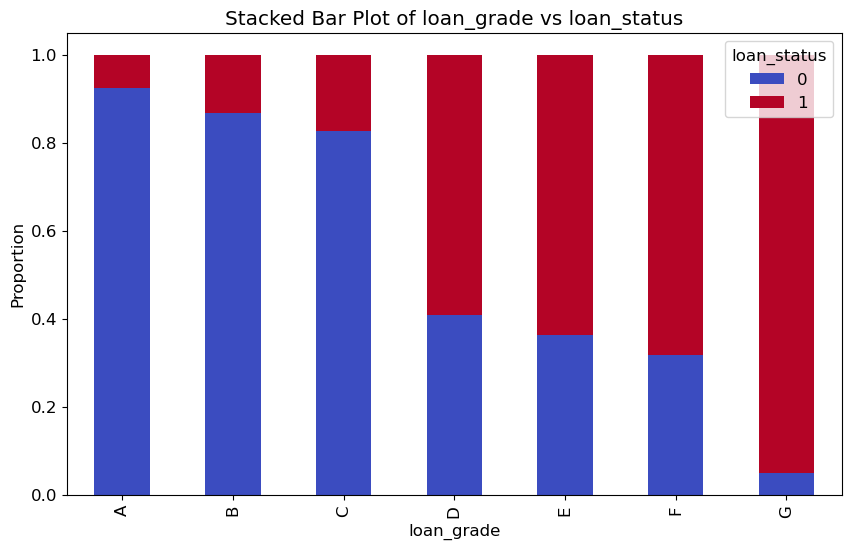

In [27]:
def stacked_bar_plot(df, feature, target=dep_var):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
    plt.title(f'Stacked Bar Plot of {feature} vs {target}')
    plt.ylabel('Proportion')
    plt.show()

stacked_bar_plot(train, 'loan_grade')

The plot shows A is the best status and G is the worst, where 0 is approval and 1 is denied. Let's make `loan_grade` ordinal. Seems like we can seperate it into {A, B, C}, {D, E, F}, and {G}. We can try that later.

In [28]:
df['loan_grade'] = df['loan_grade'].astype('category')
df['loan_grade'] = df['loan_grade'].cat.as_ordered()

In [29]:
df['loan_grade']

0        B
1        C
2        A
3        B
4        A
        ..
39093    B
39094    A
39095    A
39096    D
39097    B
Name: loan_grade, Length: 162739, dtype: category
Categories (7, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G']

## Category vs. continuous

By using `fastai`, we can find categorical data and categorify them easily.

In [30]:
procs = [Categorify, FillMissing]

In [31]:
cont_cols, cat_cols = cont_cat_split(df, dep_var=dep_var)
cont_cols, cat_cols

(['person_age',
  'person_income',
  'person_emp_length',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length'],
 ['person_home_ownership',
  'loan_intent',
  'loan_grade',
  'cb_person_default_on_file'])

We will put aside 20% of data for validation.

In [32]:
def split_idxs(df, seed = 42, valid_ratio = 0.2):
    np.random.seed(seed)
    n_idxs = len(df)
    shuffled_idxs = np.random.permutation(n_idxs)
    split_idxs = int(n_idxs * valid_ratio)
    vld_idxs = shuffled_idxs[:split_idxs]
    trn_idxs = shuffled_idxs[split_idxs:]
    return (list(trn_idxs), list(vld_idxs))

In [33]:
splits = split_idxs(train)

In [34]:
to = TabularPandas(train, procs, cat_cols, cont_cols, y_names=dep_var, splits=splits)

In [35]:
len(to.train),len(to.valid)

(98913, 24728)

We can see the data after the transformation by `fastai`.

In [36]:
to.show(3)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
15233,OWN,EDUCATION,B,N,23,24000,5.0,7000,11.86,0.29,4,0
22395,MORTGAGE,HOMEIMPROVEMENT,C,N,34,55000,6.0,2500,13.49,0.05,7,0
19264,RENT,EDUCATION,C,Y,27,25800,11.0,2500,10.99,0.10,5,0


In [37]:
to.items.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
15233,23,24000,3,5.0,...,0.29,1,4,0
22395,34,55000,1,6.0,...,0.05,1,7,0
19264,27,25800,4,11.0,...,0.10,2,5,0


`loan_grade` still has the order.

In [38]:
to.classes['loan_grade']

['#na#', 'A', 'B', 'C', 'D', 'E', 'F', 'G']

In [39]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Random Forest

Using random forest, we can train quickly and interpret results. We are not concered too much on getting the highest score possible. We want to explore quickly and try different strategies.

In [40]:
def m_roc(m, xs, y): return roc_auc_score(y, m.predict(xs))

In [41]:
def rf(xs, y, n_estimators=60, max_samples=20_000,
       max_features=0.5, min_samples_leaf=30, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=roc_auc_score).fit(xs, y)

In [42]:
m = rf(xs, y)

Train and validation score. They are exactly the same as taking the average of predictions from each tree.

In [43]:
m_roc(m, xs, y), m_roc(m, valid_xs, valid_y)

(0.9472654923777237, 0.9364733481450463)

In [44]:
# Train
preds = np.stack([t.predict(xs) for t in m.estimators_])
roc_auc_score(y, preds.mean(0))

0.9472654923777237

In [45]:
# Validation
valid_preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
roc_auc_score(valid_y, valid_preds.mean(axis=0))

0.9364733481450463

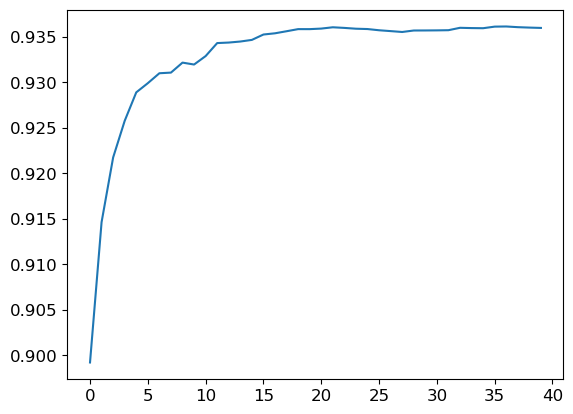

In [46]:
plt.plot([roc_auc_score(valid_y, valid_preds[:i+1].mean(0)) for i in range(40)]);

`oob_score` is similar to validation score.

In [47]:
m.oob_score_

0.9361346192697295

# Model Interpretation

## Tree variance for prediction confidence

When deciding whether we want to give someone a loan, we also want to know how confident we are. 

By looking at the standard deviation of predictions by each tree, we can see how confident we are. If standard deviation is low, all trees agree with each other, and vice versa.

In [48]:
valid_preds.shape

(60, 24728)

In [49]:
valid_preds.std(axis=0)[:10]

array([0.0758752 , 0.06076216, 0.08129557, 0.07562344, 0.03596432, 0.1055106 , 0.02909337, 0.03551291, 0.20627633, 0.06444158])

Looking at the standard deviations, they are low and with similar values except for some that goes over 0.1. Why do our trees not agree with each other? It may be worth studying in depth in the future. There may be some features we could come up with to improve our trees.

## Feature importance

Another important thing we want to know is how we made certain decisions. If we rejected a loan, we want to be able to give a reason. We can say the loan grade was too low or loan amount was too high, etc.

In [50]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [51]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
9,loan_percent_income,0.305433
2,loan_grade,0.210349
0,person_home_ownership,0.158149
5,person_income,0.098298
8,loan_int_rate,0.075580
1,loan_intent,0.073193
6,person_emp_length,0.039138
7,loan_amnt,0.025933
3,cb_person_default_on_file,0.005332
4,person_age,0.005031


The feature importances are normalized so that they add up to 1. 

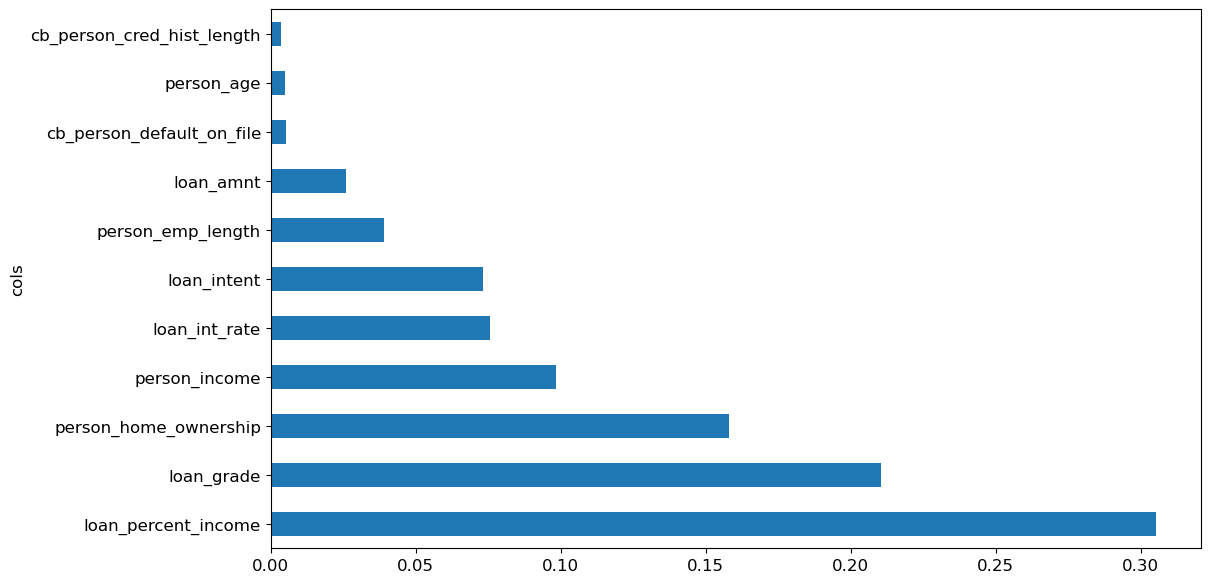

In [52]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

We can add more features and see how the importance changes.

## Removing Low-Importance Variables

Let's try removing low-importance variables and see whether we can simplify our model. If feature importance is less than 0.005, it is most likely random noise, so we want to remove that.

In [53]:
fi[fi.imp<0.005].cols

10    cb_person_cred_hist_length
Name: cols, dtype: object

In [54]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

10

In [55]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [56]:
m = rf(xs_imp, y, n_estimators=60, min_samples_leaf=30)

By removing them, we got a slight increase in score.

In [57]:
m_roc(m, xs_imp, y), m_roc(m, valid_xs_imp, valid_y)

(0.948024154158467, 0.9369818794900033)

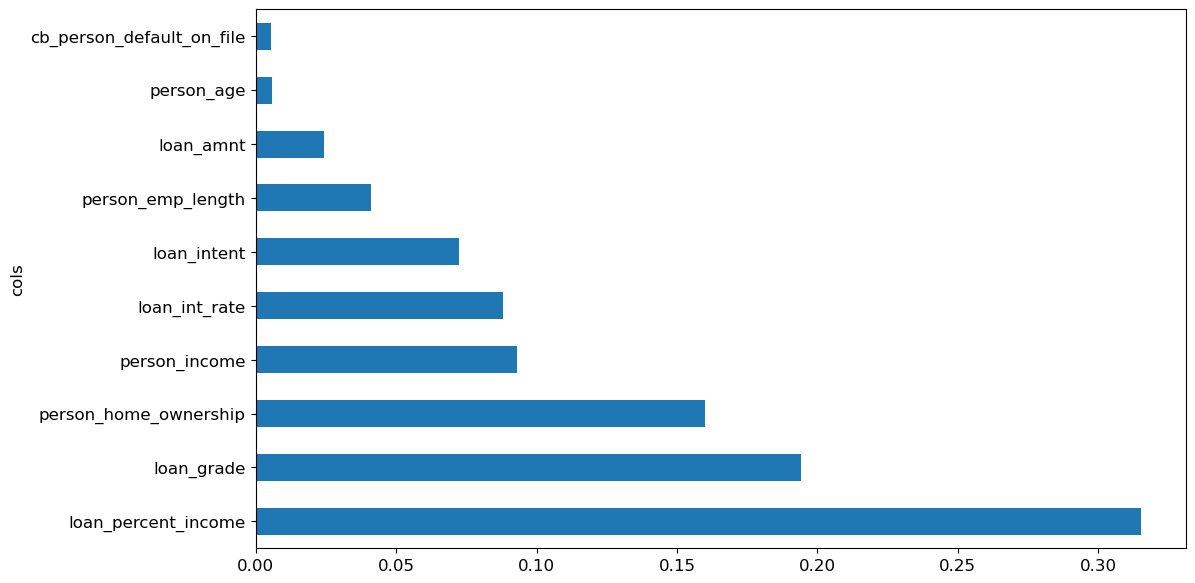

In [58]:
plot_fi(rf_feat_importance(m, xs_imp));

## Removing Redundant Features

Let's look at redundant features. They are calculated by correlation. Two features are related to each other if they branched out closer to the right on the graph. From the graph, `loan_int_rate` and `loan_grade` are very close.

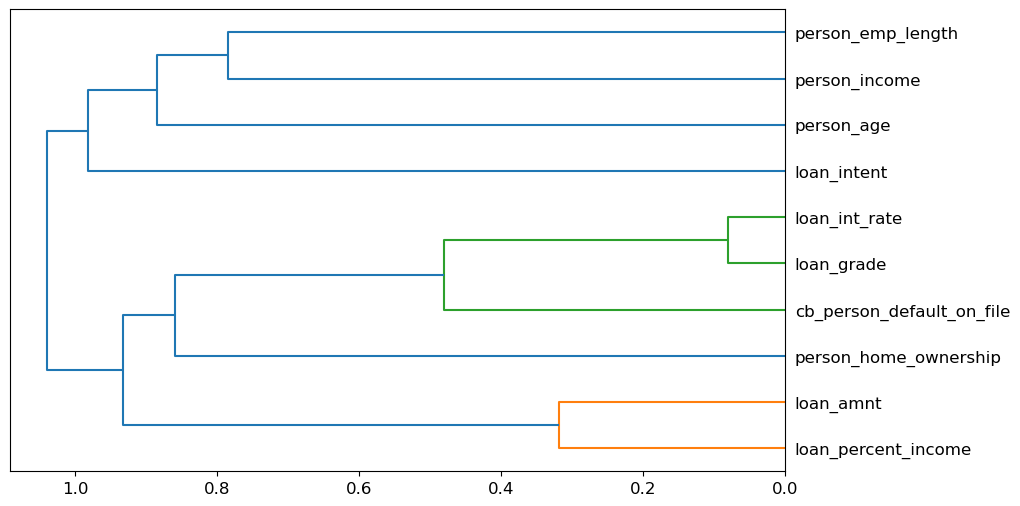

In [59]:
cluster_columns(xs_imp)

In [60]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=60, min_samples_leaf=30,
        max_samples=20_000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

`oob_score` here uses R squared.

In [61]:
# Baseline
get_oob(xs_imp)

0.6329617628169413

We try removing each feature and see how it affects the basline score.

In [62]:
{c: get_oob(xs_imp.drop(c, axis=1)) for c in ('loan_int_rate', 'loan_grade', 'loan_amnt', 'loan_percent_income')}

{'loan_int_rate': 0.6326332889930935,
 'loan_grade': 0.5831996743725688,
 'loan_amnt': 0.6302516365506008,
 'loan_percent_income': 0.5969138374124655}

Let's drop `loan_int_rate`, which is closely correlated to `loan_grade`.

In [63]:
to_drop = ['loan_int_rate']
get_oob(xs_imp.drop(to_drop, axis=1))

0.6319259981230557

In [64]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [65]:
xs_final

,loan_percent_income,loan_grade,person_home_ownership,person_income,...,person_emp_length,loan_amnt,cb_person_default_on_file,person_age
15233,0.29,2,3,24000,...,5.0,7000,1,23
22395,0.05,3,1,55000,...,6.0,2500,1,34
19264,0.10,3,4,25800,...,11.0,2500,2,27
28758,0.14,6,1,61455,...,1.0,10000,1,29
31524,0.06,4,1,100000,...,0.0,6000,1,39
...,...,...,...,...,...,...,...,...,...
28819,0.11,1,1,180000,...,2.0,20000,1,29
12634,0.11,2,4,28000,...,0.0,3000,1,23
860,0.03,1,1,90000,...,0.0,3350,1,32
15795,0.03,3,1,110000,...,2.0,3000,2,27


In [66]:
m = rf(xs_final, y)
m_roc(m, xs_final, y), m_roc(m, valid_xs_final, valid_y)

(0.9456527534522958, 0.936532254195919)

Dropping a redundant feature was not very helpful, perhaps because the features were not as correlated as before.

# Submission

Let's submit. We do the same transformation on test dataset and make predictions. We also use the model without `cb_person_cred_hist_length`.

In [67]:
m = rf(xs_imp, y, n_estimators=60, min_samples_leaf=30)

In [68]:
to2 = TabularPandas(test, procs, cat_cols, cont_cols)
len(to2.train),len(to2.valid)

(39098, 0)

In [69]:
test_xs = to2.train.xs
test_xs_imp = test_xs[to_keep]

In [70]:
test_preds = m.predict(test_xs_imp)
test_preds

array([0.94440051, 0.0468192 , 0.46332323, ..., 0.03121317, 0.47525814, 0.94678977])

In [71]:
## create submission
ss = pd.read_csv(path/"sample_submission.csv", low_memory=False)
submission = ss[['id']].copy()
submission['loan_status'] = test_preds

submission.to_csv('submission.csv', index=False)
submission

,id,loan_status
0,58645,0.944401
1,58646,0.046819
2,58647,0.463323
3,58648,0.029896
4,58649,0.220039
...,...,...
39093,97738,0.116550
39094,97739,0.023073
39095,97740,0.031213
39096,97741,0.475258


# TODO

- Look at the partial dependence plot.
- Use tree interpreter
- Find out-of-domain data
- Find features that might be useful.

In [73]:
if not iskaggle:
    push_notebook('juhyunsuh', 'playgrounds4e10-random-forest',
                  title='playgrounds4e10-random-forest',
                  file='playgrounds4e10-random-forest.ipynb',
                  competition=comp, private=False, gpu=False)

Kernel version 5 successfully pushed.  Please check progress at https://www.kaggle.com/juhyunsuh/playgrounds4e10-random-forest
